# Assignment 3: Variational Autoencoder (VAE) 
**Student Name:** Lakshit Gupta  
**Enrollment No:** E23CSEU0992  
**Date:** January 27, 2026

## Objective
The objective of this lab is to understand and implement a Variational Autoencoder 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 128
latent_dim = 20
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100.0%
100.0%
100.0%
100.0%


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


In [5]:
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28*28), reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(
        1 + log_var - mu.pow(2) - log_var.exp()
    )

    return recon_loss + kl_loss


In [6]:
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, log_var = model(data)
        loss = vae_loss(recon, data, mu, log_var)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 176.6176
Epoch [2/20], Loss: 127.5195
Epoch [3/20], Loss: 116.6852
Epoch [4/20], Loss: 112.3507
Epoch [5/20], Loss: 109.9582
Epoch [6/20], Loss: 108.2279
Epoch [7/20], Loss: 106.9092
Epoch [8/20], Loss: 105.8294
Epoch [9/20], Loss: 104.8888
Epoch [10/20], Loss: 104.1243
Epoch [11/20], Loss: 103.4998
Epoch [12/20], Loss: 102.7721
Epoch [13/20], Loss: 102.3042
Epoch [14/20], Loss: 101.8405
Epoch [15/20], Loss: 101.3921
Epoch [16/20], Loss: 101.1482
Epoch [17/20], Loss: 100.8130
Epoch [18/20], Loss: 100.5284
Epoch [19/20], Loss: 100.3082
Epoch [20/20], Loss: 100.0458


In [8]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decoder(z).cpu()


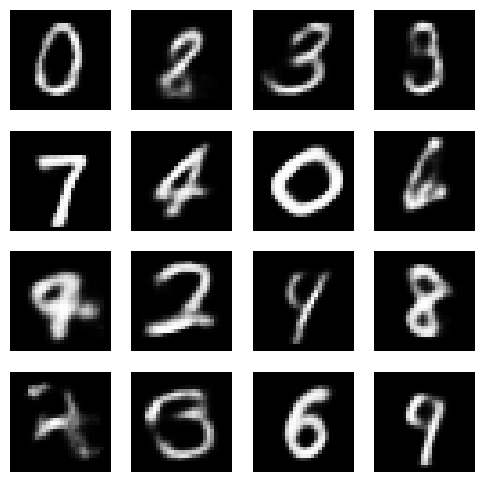

In [9]:
# Visualize generated images
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].view(28,28), cmap='gray')
    ax.axis('off')
plt.show()


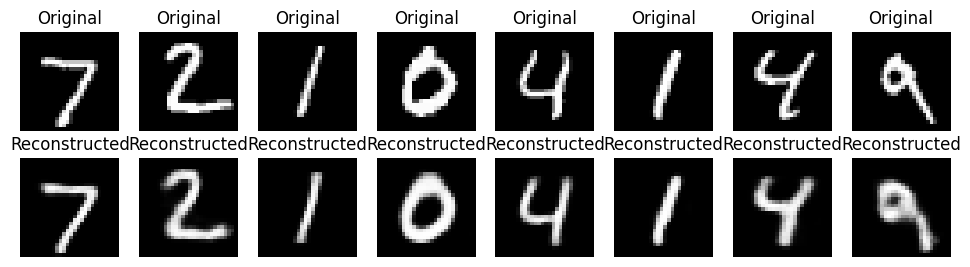

In [10]:
data, _ = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    recon, _, _ = model(data)

fig, axes = plt.subplots(2, 8, figsize=(12,3))
for i in range(8):
    axes[0, i].imshow(data[i].cpu().view(28,28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    axes[1, i].imshow(recon[i].cpu().view(28,28), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.show()


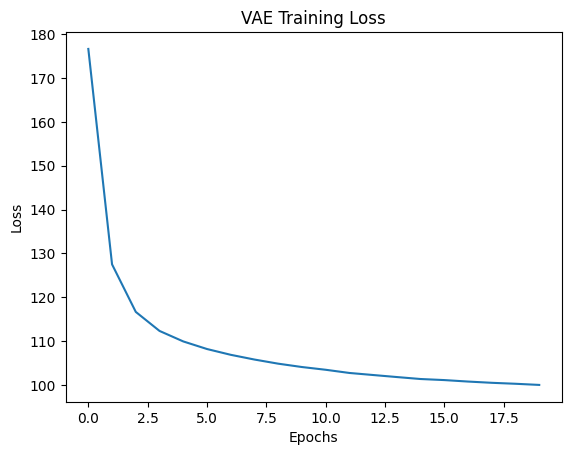

In [11]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()
